# DR Program Metrics

Demonstrates the metrics to look at for demand response programs. Uses CISO 2022 data as example

https://www.eia.gov/electricity/gridmonitor/about

In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime
import numpy as np

# Processing 

In [5]:
dfs = [
    pd.read_csv("./../../data/usa-2022/EIA930_BALANCE_2022_Jan_Jun.csv"),
    pd.read_csv("./../../data/usa-2022/EIA930_BALANCE_2022_Jul_Dec.csv"),
]
df = pd.concat(dfs)
# df = df[df["Region"] == "Cal"]

/tmp/ipykernel_598087/551080937.py:2: DtypeWarning: Columns (5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,25,26,27,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("./../../data/usa-2022/EIA930_BALANCE_2022_Jan_Jun.csv"),
/tmp/ipykernel_598087/551080937.py:3: DtypeWarning: Columns (5,6,7,8,9,10,11,13,14,15,16,17,18,19,20,21,22,23,25,26,27,29,31,32,33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("./../../data/usa-2022/EIA930_BALANCE_2022_Jul_Dec.csv"),


### Get Raw 930 Data for California

In [8]:
cal = df[df["Balancing Authority"] == "CISO"].copy()
cal['date_column'] = pd.to_datetime(cal['Data Date'], format='%m/%d/%Y')
cal['hour_column'] = cal['Hour Number'].astype(str).apply(lambda x: '00' if x == '24' else x)
cal = cal[~(cal['hour_column'] == "25")]
cal['datetime_column'] = cal['date_column'].dt.strftime('%Y-%m-%d') + ' ' + cal['hour_column'] + ':00:00'
cal['datetime_column'] = pd.to_datetime(cal['datetime_column'], format='%Y-%m-%d %H:%M:%S')
cal.head(3)

,Balancing Authority,Data Date,Hour Number,Local Time at End of Hour,UTC Time at End of Hour,Demand Forecast (MW),Demand (MW),Net Generation (MW),Total Interchange (MW),Sum(Valid DIBAs) (MW),...,Net Generation (MW) from Nuclear (Adjusted),Net Generation (MW) from All Petroleum Products (Adjusted),Net Generation (MW) from Hydropower and Pumped Storage (Adjusted),Net Generation (MW) from Solar (Adjusted),Net Generation (MW) from Wind (Adjusted),Net Generation (MW) from Other Fuel Sources (Adjusted),Region,date_column,hour_column,datetime_column
30402,CISO,01/01/2022,1,01/01/2022 1:00:00 AM,01/01/2022 9:00:00 AM,"22,631","22,321","13,064","-8,095","-8,095",...,"2,265",46.0,"1,235",-31,"2,729",231,CAL,2022-01-01,1,2022-01-01 01:00:00
30403,CISO,01/01/2022,2,01/01/2022 2:00:00 AM,01/01/2022 10:00:00 AM,"21,766","21,504","12,499","-8,003","-8,003",...,"2,265",46.0,"1,215",-31,"2,188",69,CAL,2022-01-01,2,2022-01-01 02:00:00
30404,CISO,01/01/2022,3,01/01/2022 3:00:00 AM,01/01/2022 11:00:00 AM,"21,105","21,050","11,790","-8,039","-8,039",...,"2,266",46.0,948,-31,"1,882",-56,CAL,2022-01-01,3,2022-01-01 03:00:00


### Get Load Profiles

In [9]:
load = cal.copy()
load = load.set_index("datetime_column")
load = load[["Demand (MW)", "Net Generation (MW) from Solar (Adjusted)", "Net Generation (MW) from Wind (Adjusted)"]]
load = load.rename(columns={
    "Net Generation (MW) from Solar (Adjusted)": "Solar (MW)", 
    "Net Generation (MW) from Wind (Adjusted)": "Wind (MW)"
})
load["Demand (MW)"] = load["Demand (MW)"].str.replace(",","").astype(float)
load["Solar (MW)"] = load["Solar (MW)"].str.replace(",","").astype(float)
load["Wind (MW)"] = load["Wind (MW)"].str.replace(",","").astype(float)
load["Net Load (MW)"] = load["Demand (MW)"] - load["Solar (MW)"] - load["Wind (MW)"]
load.head()

,Demand (MW),Solar (MW),Wind (MW),Net Load (MW)
datetime_column,,,,
2022-01-01 01:00:00,22321.0,-31.0,2729.0,19623.0
2022-01-01 02:00:00,21504.0,-31.0,2188.0,19347.0
2022-01-01 03:00:00,21050.0,-31.0,1882.0,19199.0
2022-01-01 04:00:00,20874.0,-32.0,1693.0,19213.0
2022-01-01 05:00:00,20895.0,-32.0,1433.0,19494.0


<Axes: xlabel='datetime_column'>

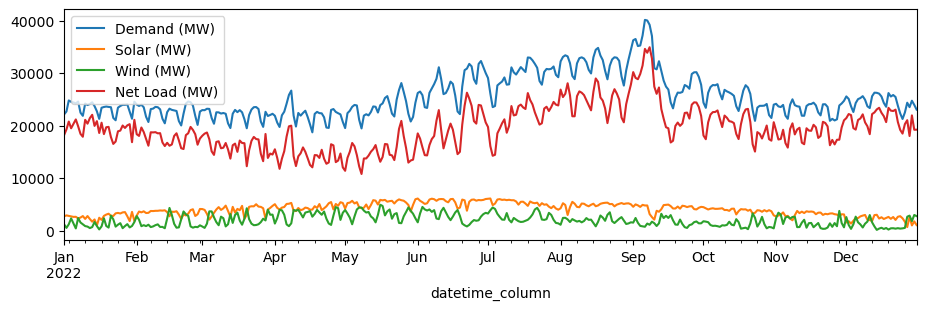

In [22]:
load.resample("d").mean().plot(figsize=(11,3))

# DR Shed Season

#### Get the top 100 loads over the year 

In [19]:
net_load_100 = (
    load
    .copy()
    .dropna()
    .sort_values("Net Load (MW)", ascending=False)
    .reset_index()
)
load_100_highest = net_load_100.at[100, "Net Load (MW)"]
load_100_highest

36564.0

Text(2022-01-01 00:00:00, 38000, 'Highest Probability Demand Response Events')

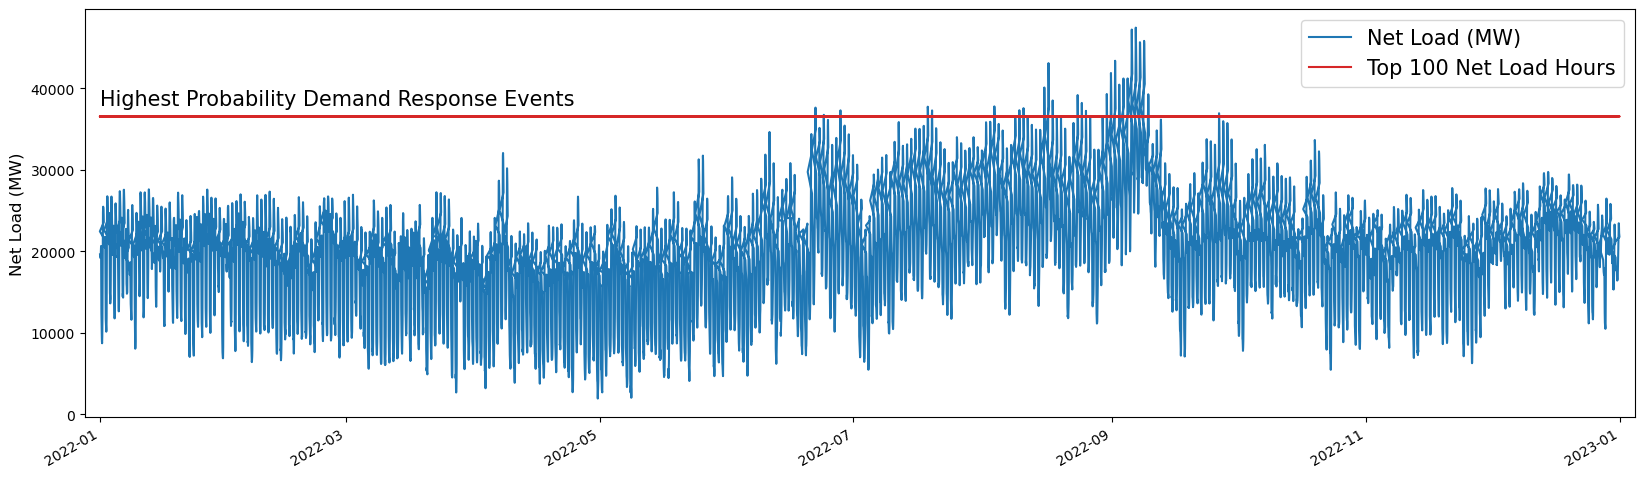

In [21]:
net_load = load.copy()
net_load["Top 100 Net Load Hours"] = load_100_highest
fig, ax = plt.subplots(figsize=(20,6))
net_load[["Net Load (MW)", "Top 100 Net Load Hours"]].plot(
    ax=ax,
    xlabel="",
    color=["tab:blue", "tab:red"]
)
ax.set_ylabel("Net Load (MW)", fontsize=12)
ax.margins(x=0.01)
ax.legend(fontsize=15)
ax.text(datetime.datetime(2022,1,1), 38000, "Highest Probability Demand Response Events", fontsize=15)

#### Get shortest duration of top 80 within this period

First get time between each demand peak  

In [25]:
load_80 = net_load_100.copy()
load_80 = load_80.iloc[:101,:] # keep end point 
load_80 = load_80.sort_values("datetime_column").reset_index(drop=True)
diff = []
for row in range(len(load_80)):
    try:
        start = load_80.loc[row, "datetime_column"]
        end = load_80.loc[row+1, "datetime_column"]
        diff.append(
            end - start
        )
    except KeyError:
        pass
load_80 = load_80.iloc[:100,:] # remove end point 
load_80["diff"] = diff
load_80.head()

,datetime_column,Demand (MW),Solar (MW),Wind (MW),Net Load (MW),diff
0,2022-06-21 20:00:00,39271.0,1305.0,840.0,37126.0,0 days 01:00:00
1,2022-06-21 21:00:00,38524.0,-35.0,912.0,37647.0,2 days 00:00:00
2,2022-06-23 21:00:00,39071.0,6.0,2307.0,36758.0,3 days 23:00:00
3,2022-06-27 20:00:00,41186.0,1437.0,2623.0,37126.0,0 days 01:00:00
4,2022-06-27 21:00:00,40373.0,49.0,3014.0,37310.0,20 days 23:00:00


Remove first or last point based on longest duration 

In [26]:
load_shortest = load_80.copy()
while len(load_shortest) > 80:
    start_diff = load_shortest["diff"].iloc[0]
    end_diff = load_shortest["diff"].iloc[-1]
    if start_diff > end_diff:
        load_shortest = load_shortest.iloc[1:,:]
    else:
        load_shortest = load_shortest.iloc[:-1,:]
    load_shortest = load_shortest.reset_index(drop=True)
load_shortest.head()

,datetime_column,Demand (MW),Solar (MW),Wind (MW),Net Load (MW),diff
0,2022-06-21 20:00:00,39271.0,1305.0,840.0,37126.0,0 days 01:00:00
1,2022-06-21 21:00:00,38524.0,-35.0,912.0,37647.0,2 days 00:00:00
2,2022-06-23 21:00:00,39071.0,6.0,2307.0,36758.0,3 days 23:00:00
3,2022-06-27 20:00:00,41186.0,1437.0,2623.0,37126.0,0 days 01:00:00
4,2022-06-27 21:00:00,40373.0,49.0,3014.0,37310.0,20 days 23:00:00


In [27]:
load_80_start = load_shortest.at[0, "datetime_column"] 
load_80_end = load_shortest.at[79, "datetime_column"] 

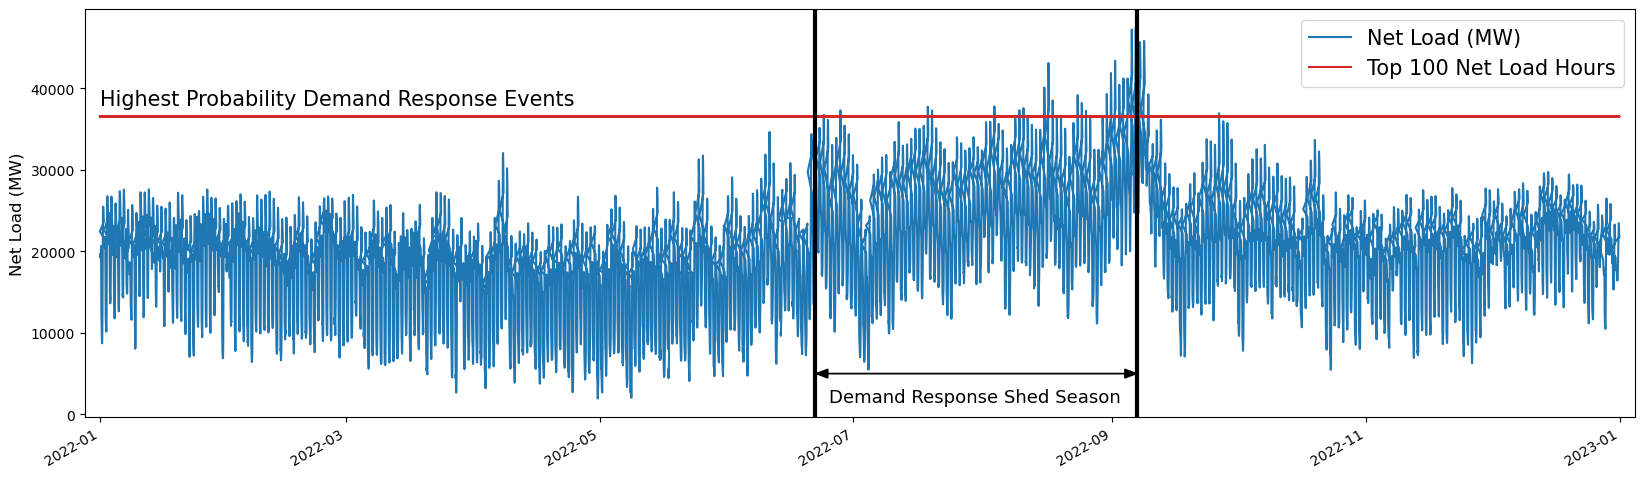

In [28]:
net_load = load.copy()
net_load["Top 100 Net Load Hours"] = load_100_highest
fig, ax = plt.subplots(figsize=(20,6))
net_load[["Net Load (MW)", "Top 100 Net Load Hours"]].plot(
    ax=ax,
    xlabel="",
    color=["tab:blue", "tab:red"]
)
ax.set_ylabel("Net Load (MW)", fontsize=12)
ax.margins(x=0.01)
ax.legend(fontsize=15)
ax.text(datetime.datetime(2022,1,1), 38000, "Highest Probability Demand Response Events", fontsize=15)
ax.text(datetime.datetime(2022,6,25), 1500, "Demand Response Shed Season", fontsize=13)
# ax.arrow(datetime.datetime(2022,6,22), 5000, 72, 0, head_width = 1000, head_length=5, color="k", fill=True)
# ax.arrow(datetime.datetime(2022,9,7), 5000, -72, 0, head_width = 1000, head_length=5, color="k", fill=True)
ax.annotate(
    text="", 
    xy=(datetime.datetime(2022,6,21),5000),
    xytext=(datetime.datetime(2022,9,8),5000),
    arrowprops=dict(
        arrowstyle="<|-|>",
        mutation_scale = 20, 
        mutation_aspect = 0.75,
        color="k", 
        fill=True,
        linewidth=1.25
        )
    )
ax.axvline(x=load_80_start, color="k", linestyle="-", linewidth=3)
ax.axvline(x=load_80_end, color="k", linestyle="-", linewidth=3)

fig.savefig("dr-shed-season.png", dpi=400)

### Count Shed Event Days
These are number of days within shed season 

In [29]:
net_load_top_days = load.copy()
net_load_top_days = net_load_top_days.dropna()
net_load_top_days = net_load_top_days.sort_values("Net Load (MW)", ascending=False)
net_load_top_days["day"] = net_load_top_days.index.map(lambda x: x.date())
net_load_top_days = net_load_top_days.reset_index()
net_load_top_days = net_load_top_days.iloc[:100]
net_load_top_days = net_load_top_days.drop_duplicates(subset=["day"])
net_load_top_days.head()

,datetime_column,Demand (MW),Solar (MW),Wind (MW),Net Load (MW),day
0,2022-09-06 19:00:00,50378.0,1765.0,1149.0,47464.0,2022-09-06
1,2022-09-05 20:00:00,47961.0,94.0,639.0,47228.0,2022-09-05
3,2022-09-08 19:00:00,47894.0,1010.0,1047.0,45837.0,2022-09-08
4,2022-09-07 19:00:00,49376.0,1773.0,1931.0,45672.0,2022-09-07
13,2022-09-01 20:00:00,46027.0,209.0,2421.0,43397.0,2022-09-01


In [30]:
points_to_plot = [(x,y) for x,y in zip(net_load_top_days["datetime_column"].to_list(), net_load_top_days["Net Load (MW)"].to_list())]

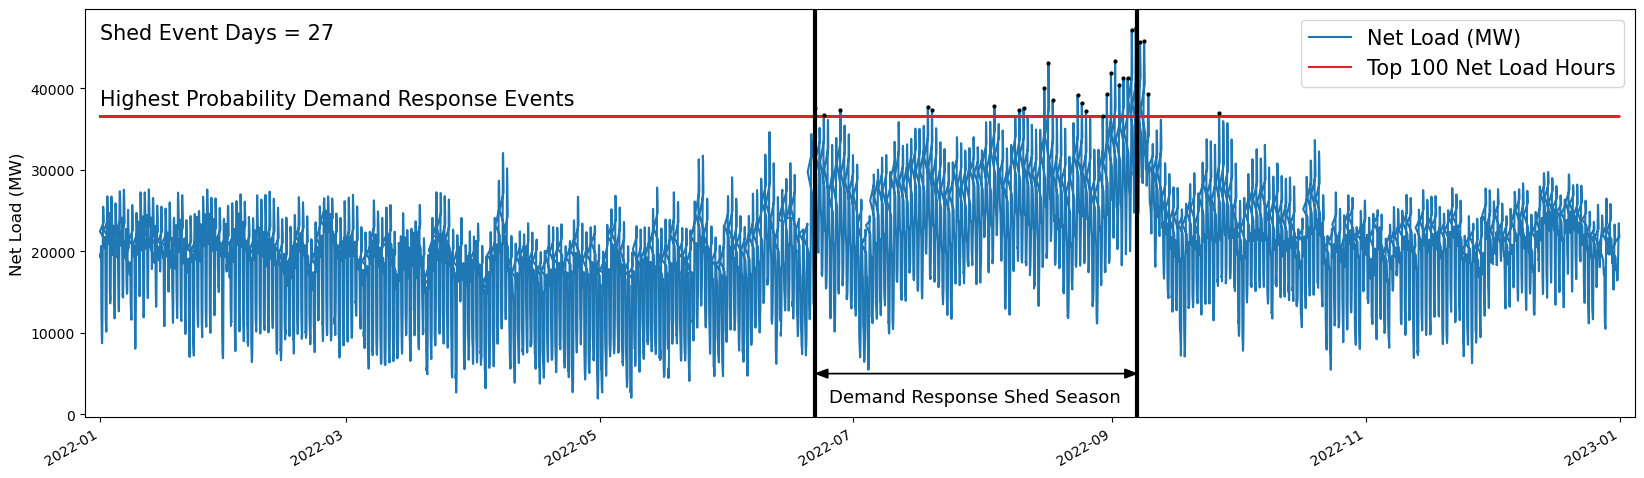

In [31]:
net_load = load.copy()
net_load["Top 100 Net Load Hours"] = load_100_highest
fig, ax = plt.subplots(figsize=(20,6))
net_load[["Net Load (MW)", "Top 100 Net Load Hours"]].plot(
    ax=ax,
    xlabel="",
    color=["tab:blue", "tab:red"]
)
ax.set_ylabel("Net Load (MW)", fontsize=12)
ax.margins(x=0.01)
ax.legend(fontsize=15)
ax.text(datetime.datetime(2022,1,1), 38000, "Highest Probability Demand Response Events", fontsize=15)
ax.text(datetime.datetime(2022,1,1), 46000, f"Shed Event Days = {len(net_load_top_days)}", fontsize=15)
ax.text(datetime.datetime(2022,6,25), 1500, "Demand Response Shed Season", fontsize=13)
ax.annotate(
    text="", 
    xy=(datetime.datetime(2022,6,21),5000),
    xytext=(datetime.datetime(2022,9,8),5000),
    arrowprops=dict(
        arrowstyle="<|-|>",
        mutation_scale = 20, 
        mutation_aspect = 0.75,
        color="k", 
        fill=True,
        linewidth=1.25
        )
    )
ax.axvline(x=load_80_start, color="k", linestyle="-", linewidth=3)
ax.axvline(x=load_80_end, color="k", linestyle="-", linewidth=3)

for point_x, point_y in points_to_plot:
    ax.plot(point_x, point_y, "o", color="k", markersize=2)

fig.savefig("figures/dr-shed-season.png", dpi=400)

# DR Shed - Peakiness

In [32]:
shed = load.copy()
shed.head()

,Demand (MW),Solar (MW),Wind (MW),Net Load (MW)
datetime_column,,,,
2022-01-01 01:00:00,22321.0,-31.0,2729.0,19623.0
2022-01-01 02:00:00,21504.0,-31.0,2188.0,19347.0
2022-01-01 03:00:00,21050.0,-31.0,1882.0,19199.0
2022-01-01 04:00:00,20874.0,-32.0,1693.0,19213.0
2022-01-01 05:00:00,20895.0,-32.0,1433.0,19494.0


In [33]:
shed_100 = (
    shed
    .copy()
    .dropna()
    .sort_values("Net Load (MW)", ascending=False)
    .reset_index()
)
shed_100_highest = shed_100.at[0, "Net Load (MW)"]
shed_100_highest_date = shed_100.at[0, "datetime_column"]
shed_100_lowest = shed_100.at[100, "Net Load (MW)"]

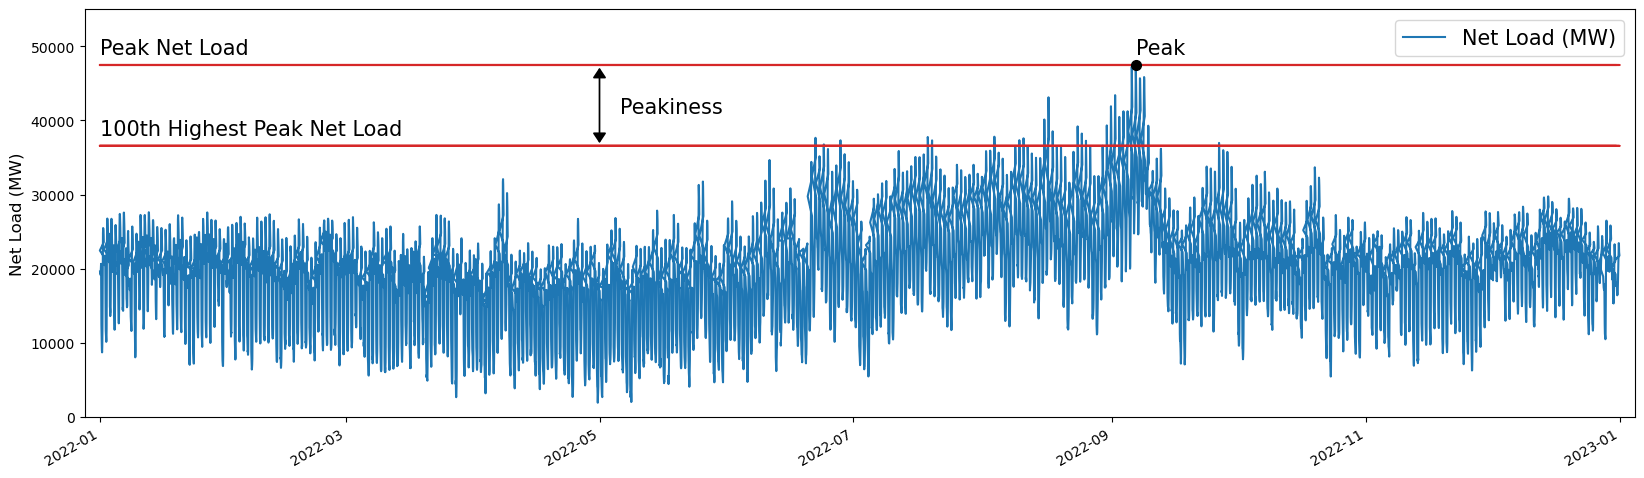

In [34]:
shed_plot = shed.copy()
shed_plot = shed_plot[["Net Load (MW)"]]
shed_plot["Peak Net Load"] = shed_100_highest
shed_plot["100th Highest Peak Load"] = shed_100_lowest

fig, ax = plt.subplots(figsize=(20,6))
shed_plot.plot(
    ax=ax,
    xlabel="",
    color=["tab:blue", "tab:red", "tab:red"]
)
for line in ax.lines:
    if line.get_label() == "Net Load (MW)":
        continue
    line.set_label("")
ax.set_ylabel("Net Load (MW)", fontsize=12)
ax.margins(x=0.01)
ax.legend(fontsize=15)
ax.set_ylim((0, 55000))
ax.text(datetime.datetime(2022,1,1), 38000, "100th Highest Peak Net Load", fontsize=15)
ax.text(datetime.datetime(2022,1,1), 49000, "Peak Net Load", fontsize=15)
ax.annotate(
    text="", 
    xy=(datetime.datetime(2022,5,1),shed_100_lowest),
    xytext=(datetime.datetime(2022,5,1),shed_100_highest),
    arrowprops=dict(
        arrowstyle="<|-|>",
        mutation_scale = 20, 
        mutation_aspect = 0.75,
        color="k", 
        fill=True,
        linewidth=1.25
        )
    )
ax.text(datetime.datetime(2022,5,6), 41000, "Peakiness", fontsize=15)
ax.plot(shed_100_highest_date, shed_100_highest, "o", color="k", markersize=7)
ax.text(shed_100_highest_date, shed_100_highest + 1500, "Peak", fontsize=15)
fig.savefig("figures/dr-shed.png", dpi=400)

# Load Shifting - Ramping

In [35]:
load.head(5)

,Demand (MW),Solar (MW),Wind (MW),Net Load (MW)
datetime_column,,,,
2022-01-01 01:00:00,22321.0,-31.0,2729.0,19623.0
2022-01-01 02:00:00,21504.0,-31.0,2188.0,19347.0
2022-01-01 03:00:00,21050.0,-31.0,1882.0,19199.0
2022-01-01 04:00:00,20874.0,-32.0,1693.0,19213.0
2022-01-01 05:00:00,20895.0,-32.0,1433.0,19494.0


In [37]:
ramp = load.copy()
ramp = ramp[["Net Load (MW)"]].rename(columns={"Net Load (MW)": "Absolute 3-hr Ramping (MW)"})
ramp = ramp.diff(periods=3)
ramp["Absolute 3-hr Ramping (MW)"] = ramp["Absolute 3-hr Ramping (MW)"].abs()

In [38]:
max_ramp = ramp.copy()
max_ramp = max_ramp.dropna().reset_index()
max_ramp = max_ramp.sort_values(by=["Absolute 3-hr Ramping (MW)"], ascending=False)
max_ramp["day"] = max_ramp["datetime_column"].map(lambda x: f"{x.month}-{x.day}")
max_ramp = max_ramp.drop_duplicates("day").reset_index(drop=True)
max_ramp_25_day = max_ramp.at[24, "datetime_column"]
max_ramp_25_value = max_ramp.at[24, "Absolute 3-hr Ramping (MW)"]
max_ramp_1_day  = max_ramp.at[0, "datetime_column"]
max_ramp_1_value  = max_ramp.at[0, "Absolute 3-hr Ramping (MW)"]

In [39]:
max_ramp.head()

,datetime_column,Absolute 3-hr Ramping (MW),day
0,2022-03-11 18:00:00,16908.0,3-11
1,2022-04-24 19:00:00,16861.0,4-24
2,2022-04-07 19:00:00,16160.0,4-7
3,2022-03-26 19:00:00,16091.0,3-26
4,2022-02-28 18:00:00,15967.0,2-28


 #### This is hourly ramping (just out of curiosity)

In [40]:
ramp_plot = ramp.copy()
ramp_plot["Routine Ramping"] = max_ramp_25_value
ramp_plot["Max Ramping"] = max_ramp_1_value

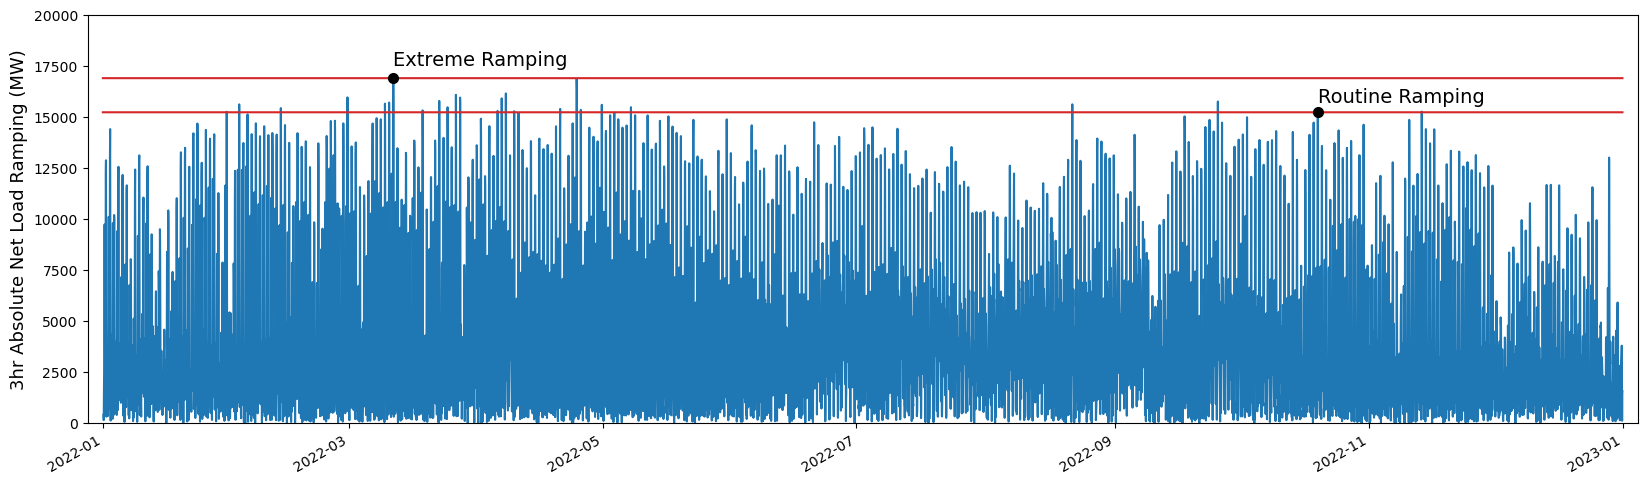

In [23]:
fig, ax = plt.subplots(figsize=(20,6))
ramp_plot.plot(
    ax=ax,
    xlabel="",
    color=["tab:blue", "tab:red", "tab:red"],
    legend=False
)
ax.set_ylabel("3hr Absolute Net Load Ramping (MW)", fontsize=13)
ax.margins(x=0.01)
# ax.legend(fontsize=15)
ax.set_ylim((0, 20000))
ax.text(max_ramp_25_day, 15700, "Routine Ramping", fontsize=14)
ax.text(max_ramp_1_day, 17500, "Extreme Ramping", fontsize=14)
# ax.text(datetime.datetime(2022,11,17), 15700, "Routine Ramping", fontsize=14)
# ax.text(datetime.datetime(2022,11,15), 17500, "Extreme Ramping", fontsize=14)
ax.plot(max_ramp_1_day, max_ramp_1_value, "o", color="k", markersize=7)
ax.plot(max_ramp_25_day, max_ramp_25_value, "o", color="k", markersize=7)
# ax.annotate(
#     text="", 
#     xy=(datetime.datetime(2022,5,1),shed_100_lowest),
#     xytext=(datetime.datetime(2022,5,1),shed_100_highest),
#     arrowprops=dict(
#         arrowstyle="<|-|>",
#         mutation_scale = 20, 
#         mutation_aspect = 0.75,
#         color="k", 
#         fill=True,
#         linewidth=1.25
#         )
#     )
# ax.text(datetime.datetime(2022,5,6), 41000, "Peakiness", fontsize=15)
# ax.plot(shed_100_highest_date, shed_100_highest, "o", color="k", markersize=7)
# ax.text(shed_100_highest_date, shed_100_highest + 1500, "Peak", fontsize=15)

#### This is max daily 3hr ramping (correct metric)

In [41]:
daily = max_ramp.copy()
daily["datetime_column"] = daily["datetime_column"].map(lambda x: x.replace(hour=0))
max_ramp_25_day = daily.at[24, "datetime_column"]
max_ramp_25_value = daily.at[24, "Absolute 3-hr Ramping (MW)"]
max_ramp_1_day  = daily.at[0, "datetime_column"]
max_ramp_1_value  = daily.at[0, "Absolute 3-hr Ramping (MW)"]
daily = daily.set_index("datetime_column").sort_index().drop(columns=["day"])
daily["Routine Ramping"] = max_ramp_25_value
daily["Max Ramping"] = max_ramp_1_value
daily.head()

,Absolute 3-hr Ramping (MW),Routine Ramping,Max Ramping
datetime_column,,,
2022-01-01,12881.0,15236.0,16908.0
2022-01-02,14412.0,15236.0,16908.0
2022-01-03,10200.0,15236.0,16908.0
2022-01-04,12563.0,15236.0,16908.0
2022-01-05,12166.0,15236.0,16908.0


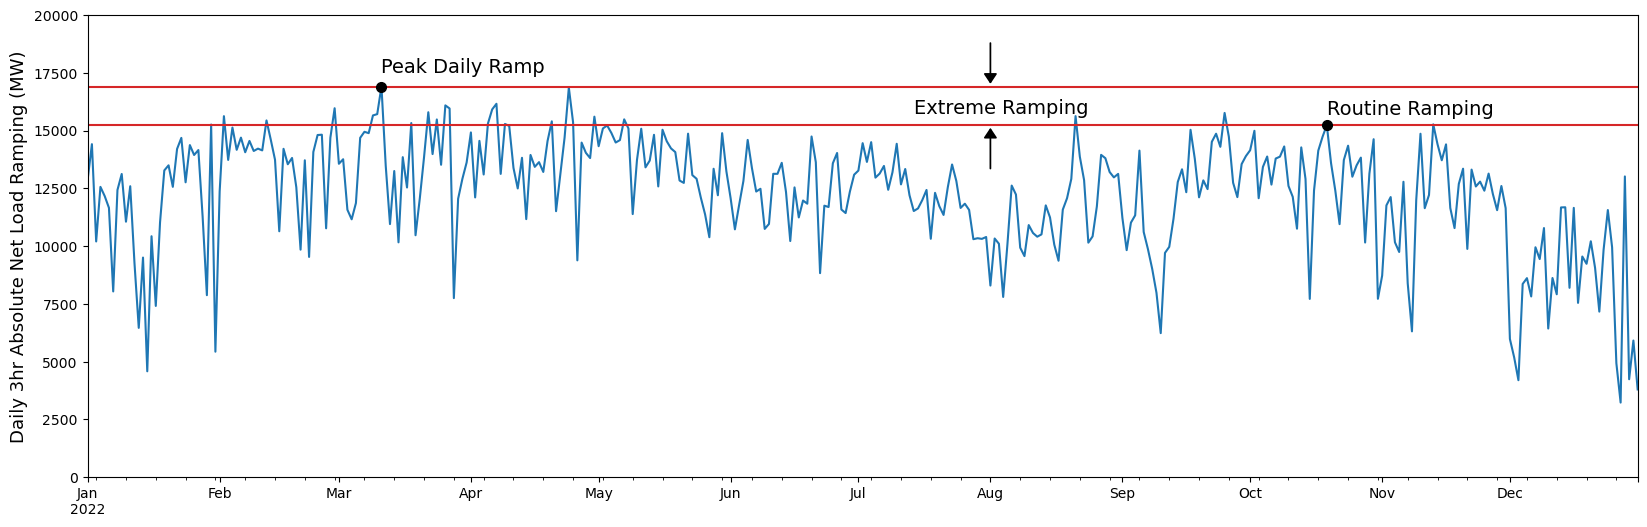

In [43]:
fig, ax = plt.subplots(figsize=(20,6))
daily.plot(
    ax=ax,
    xlabel="",
    color=["tab:blue", "tab:red", "tab:red"],
    legend=False
)
ax.set_ylabel("Daily 3hr Absolute Net Load Ramping (MW)", fontsize=13)
ax.margins(x=0.01)
# ax.legend(fontsize=15)
ax.set_ylim((0, 20000))
ax.text(max_ramp_25_day, 15700, "Routine Ramping", fontsize=14)
ax.text(max_ramp_1_day, 17500, "Peak Daily Ramp", fontsize=14)
ax.text(datetime.datetime(2022,7,14), max_ramp_25_value + 500, "Extreme Ramping", fontsize=14)
# ax.text(datetime.datetime(2022,11,17), 15700, "Routine Ramping", fontsize=14)
# ax.text(datetime.datetime(2022,11,15), 17500, "Extreme Ramping", fontsize=14)
ax.plot(max_ramp_1_day, max_ramp_1_value, "o", color="k", markersize=7)
ax.plot(max_ramp_25_day, max_ramp_25_value, "o", color="k", markersize=7)

ax.annotate(
    text="", 
    xy=(datetime.datetime(2022,8,1),max_ramp_25_value),
    xytext=(datetime.datetime(2022,8,1),(max_ramp_25_value-2000)),
    arrowprops=dict(
        arrowstyle="-|>",
        mutation_scale = 20, 
        mutation_aspect = 0.75,
        color="k", 
        fill=True,
        linewidth=1.25
        )
    )

ax.annotate(
    text="", 
    xy=(datetime.datetime(2022,8,1),max_ramp_1_value),
    xytext=(datetime.datetime(2022,8,1),(max_ramp_1_value+2000)),
    arrowprops=dict(
        arrowstyle="-|>",
        mutation_scale = 20, 
        mutation_aspect = 0.75,
        color="k", 
        fill=True,
        linewidth=1.25
        )
    )

fig.savefig("figures/dr-shift.png", dpi=400)

# DR Shift Season

#### Top 25 ramping days 

In [44]:
shift = daily.copy()
shift = shift[["Absolute 3-hr Ramping (MW)"]]
shift.head()

,Absolute 3-hr Ramping (MW)
datetime_column,
2022-01-01,12881.0
2022-01-02,14412.0
2022-01-03,10200.0
2022-01-04,12563.0
2022-01-05,12166.0


In [45]:
shift_25 = shift.copy()
shift_25 = shift.sort_values("Absolute 3-hr Ramping (MW)", ascending=False).reset_index()
shift_25 = shift_25.iloc[:26,:]
shift_25 = shift_25.sort_values("datetime_column").reset_index(drop=True)
diff = []
for row in range(len(shift_25)):
    try:
        start = shift_25.loc[row, "datetime_column"]
        end = shift_25.loc[row+1, "datetime_column"]
        diff.append(
            end - start
        )
    except KeyError:
        pass
shift_25 = shift_25.iloc[:25,:]
shift_25["diff"] = diff
shift_25.head()

,datetime_column,Absolute 3-hr Ramping (MW),diff
0,2022-01-30,15261.0,3 days
1,2022-02-02,15624.0,10 days
2,2022-02-12,15440.0,16 days
3,2022-02-28,15967.0,9 days
4,2022-03-09,15656.0,1 days


In [46]:
shift_season = shift_25.copy()
while len(shift_season) > 20:
    start_diff = shift_season["diff"].iloc[0]
    end_diff = shift_season["diff"].iloc[-1]
    if start_diff > end_diff:
        shift_season = shift_season.iloc[1:,:]
    else:
        shift_season = shift_season.iloc[:-1,:]
    shift_season = shift_season.reset_index(drop=True)
shift_season

,datetime_column,Absolute 3-hr Ramping (MW),diff
0,2022-01-30,15261.0,3 days
1,2022-02-02,15624.0,10 days
2,2022-02-12,15440.0,16 days
3,2022-02-28,15967.0,9 days
4,2022-03-09,15656.0,1 days
5,2022-03-10,15712.0,1 days
6,2022-03-11,16908.0,7 days
7,2022-03-18,15326.0,4 days
8,2022-03-22,15794.0,2 days
9,2022-03-24,15481.0,2 days


In [47]:
points_to_plot = [(x,y) for x,y in zip(shift_25["datetime_column"].to_list(), shift_25["Absolute 3-hr Ramping (MW)"].to_list())]
season_start = shift_season.loc[0,"datetime_column"]
season_end = shift_season.loc[19,"datetime_column"]
routine = shift_25.loc[24, "Absolute 3-hr Ramping (MW)"]

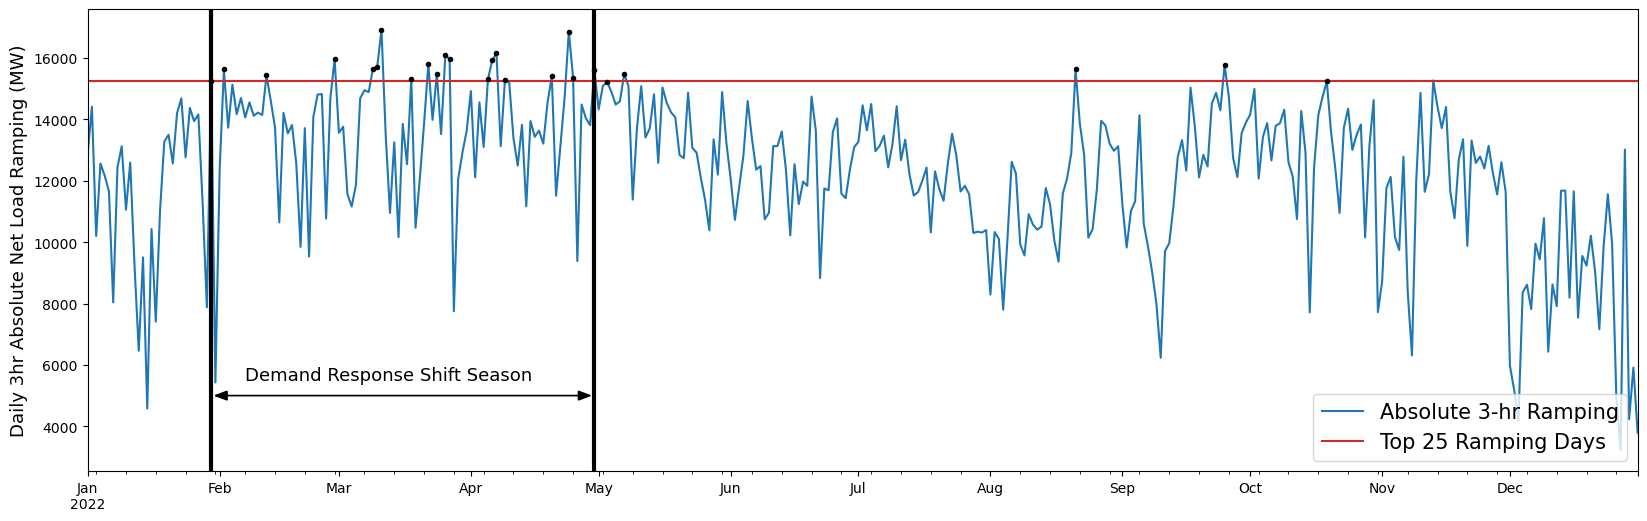

In [48]:
shift_season_plot = shift.copy()
shift_season_plot["Top 25 Ramping Days"] = routine
shift_season_plot = shift_season_plot.rename(columns={"Absolute 3-hr Ramping (MW)":"Absolute 3-hr Ramping"})
fig, ax = plt.subplots(figsize=(20,6))
shift_season_plot[["Absolute 3-hr Ramping", "Top 25 Ramping Days"]].plot(
    ax=ax,
    xlabel="",
    color=["tab:blue", "tab:red"]
)
ax.set_ylabel("Daily 3hr Absolute Net Load Ramping (MW)", fontsize=13)
ax.margins(x=0.01)
ax.legend(fontsize=15, loc="lower right")
# ax.text(datetime.datetime(2022,1,1), 38000, "Highest Probability Demand Response Events", fontsize=15)
ax.text(datetime.datetime(2022,2,7), 5500, "Demand Response Shift Season", fontsize=13)
ax.annotate(
    text="", 
    xy=(season_start,5000),
    xytext=(season_end,5000),
    arrowprops=dict(
        arrowstyle="<|-|>",
        mutation_scale = 20, 
        mutation_aspect = 0.75,
        color="k", 
        fill=True,
        linewidth=1.25
        )
    )
ax.axvline(x=season_start, color="k", linestyle="-", linewidth=3)
ax.axvline(x=season_end, color="k", linestyle="-", linewidth=3)
for point_x, point_y in points_to_plot:
    ax.plot(point_x, point_y, "o", color="k", markersize=3)

fig.savefig("figures/dr-shift-season.png", dpi=400)